# <span style="color:black"><center> Dask DataFrames: Grandes dataframes paralelizados<center></span>

## Datos

In [ ]:
## %run prep.py -d flights #vaya a la terminal en la carpeta de dask-tutorial y ejecute el comando. El archivo creado es random.hdf5 y pesa 4 GB.

In [1]:
import os
import dask
import pandas

## <span style="color:black">Configuración</span>

In [2]:
from dask.distributed import Client

client = Client(n_workers=4)

In [3]:
import dask.dataframe as dd

### Datos reales

Intentemos esto con un extracto de vuelos en los EE. UU. A lo largo de varios años. Estos datos son específicos para vuelos de los tres aeropuertos en el área de la ciudad de Nueva York (New York).

In [6]:
df = dd.read_csv(os.path.join('..Sistemas de Información/datos', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [ ]:
df.head()

In [10]:
df.tail()  

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


### Dask data.frame

In [11]:
%time df.DepDelay.max().compute()

CPU times: user 620 ms, sys: 147 ms, total: 767 ms
Wall time: 6.06 s


1435.0

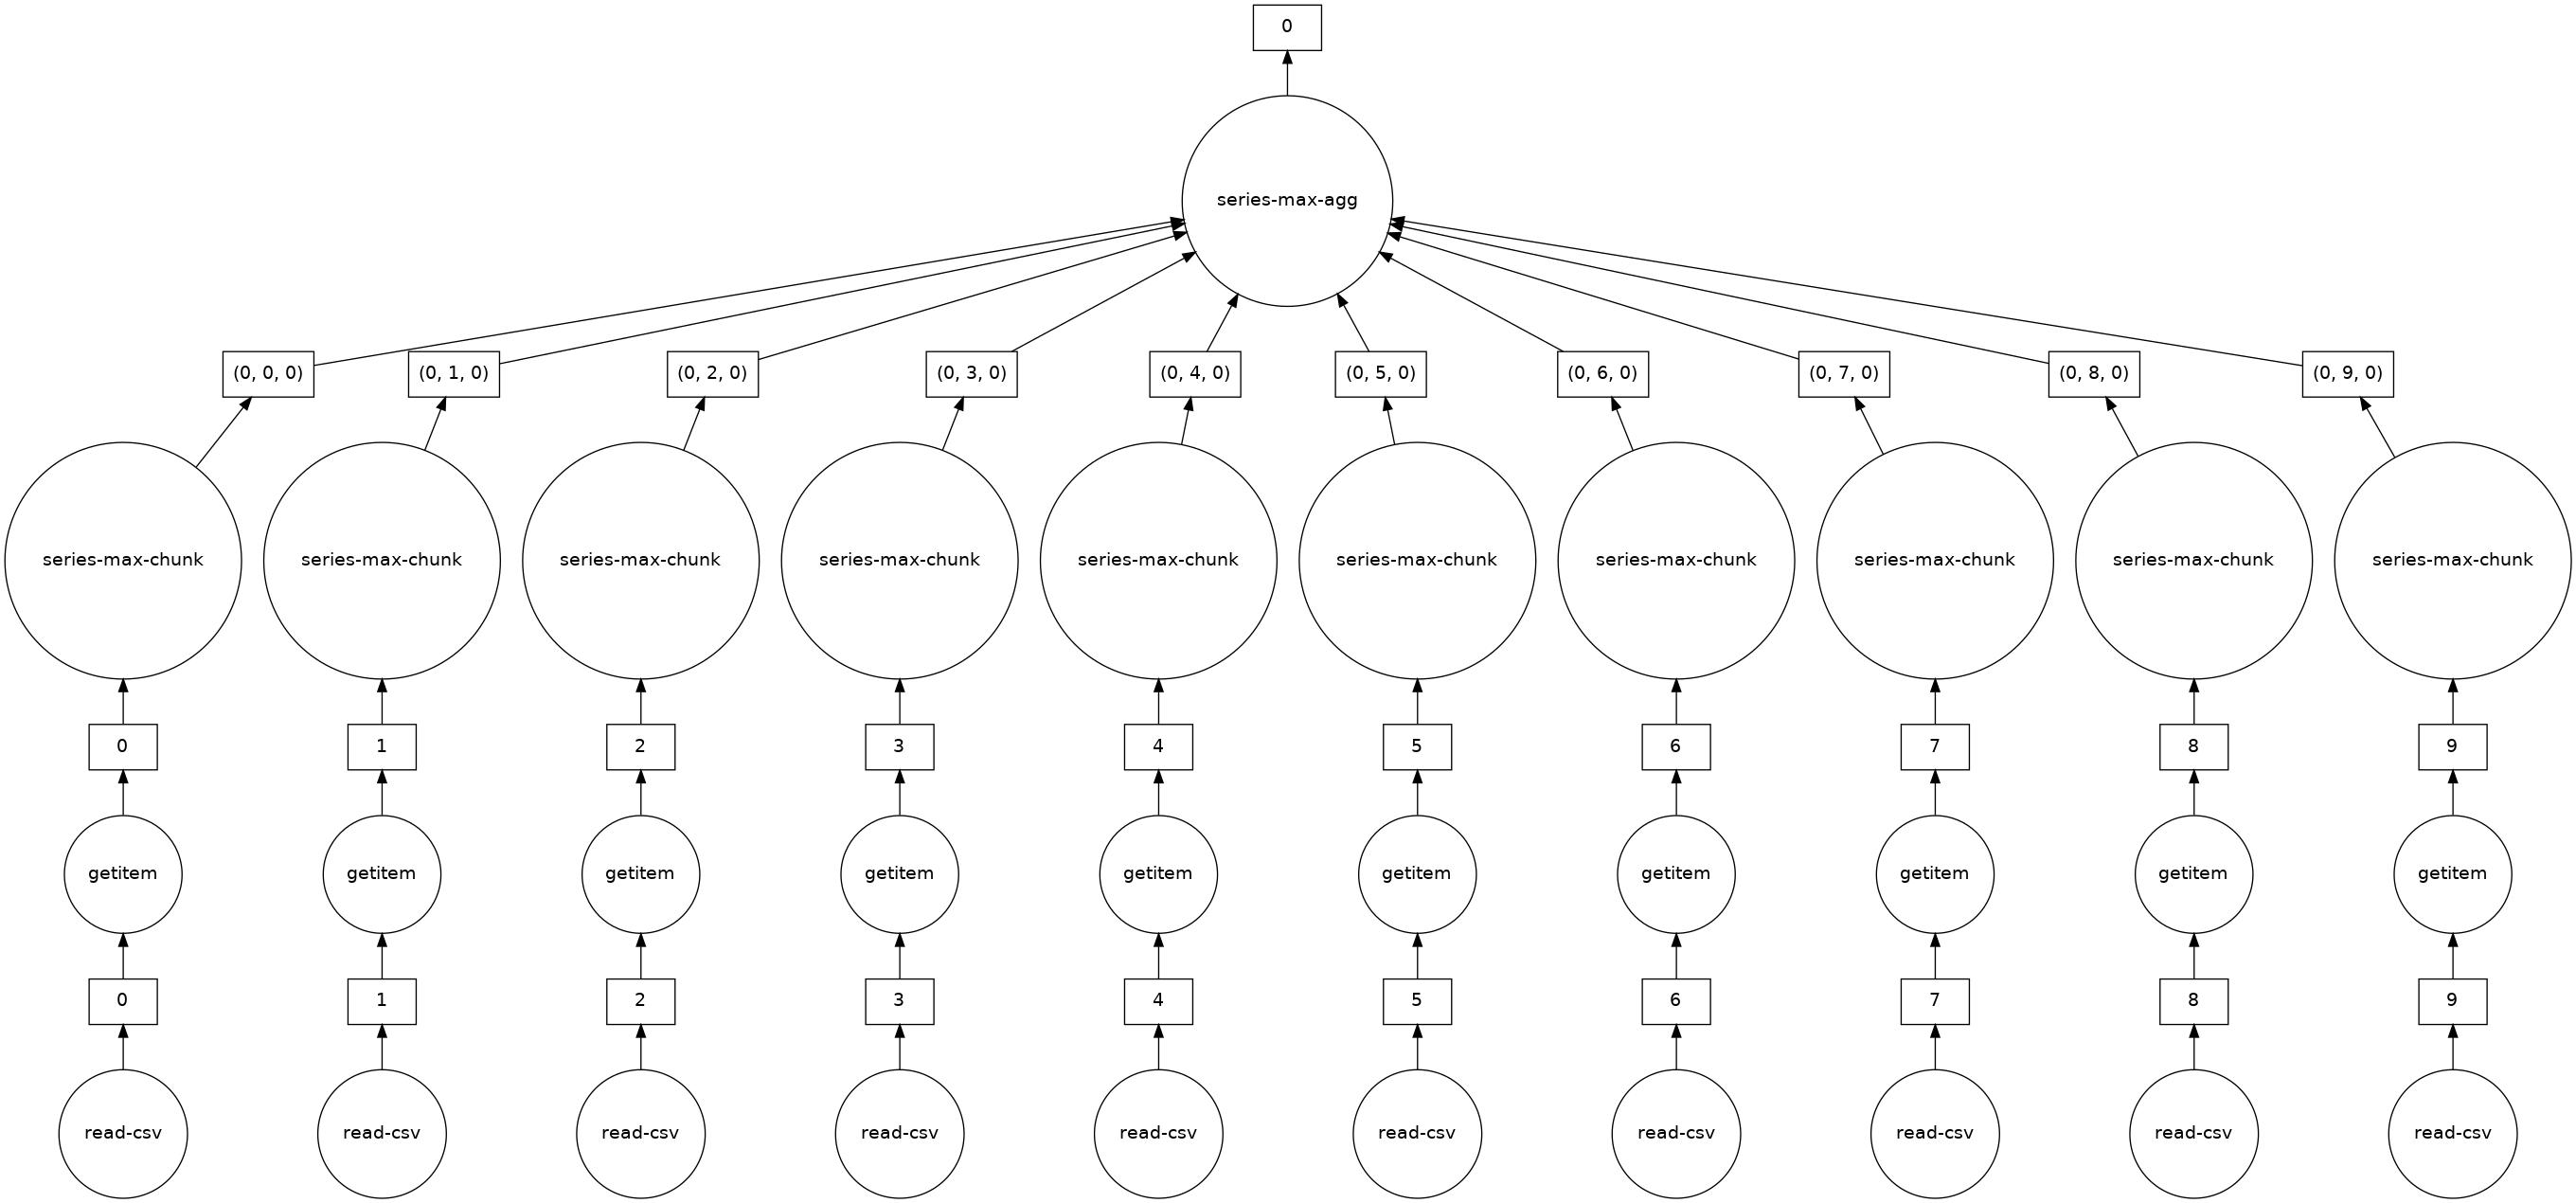

In [12]:
# notice the parallelism
df.DepDelay.max().visualize()

# Ejercicios

###  ¿Cuántas filas hay en nuestro conjunto de datos?

Si no está familiarizado con los pandas, ¿cómo comprobaría cuántos registros hay en una lista de tuplas?

In [13]:
#Código 
len(df) 

2611892

La función  <span style="color:green"> len </span> toma un argumento, que puede ser una secuencia y devuelve la longitud de un objeto, ya sea una lista, una cadena, una tupla o un diccionario. En este caso, la función calcula la longitud por cada partición de datos (cuenta el número de filas por cada archivo) y nos entrega la suma final. Es decir, en conjunto, se realizaron 2'611.892 vuelos desde el 1 enero de 1990 hasta el 31 de diciembre de 1999.

### En total, ¿cuántos vuelos no cancelados se tomaron?

Con pandas, usarías [boolean indexing](https://pandas.pydata.org/pandas-docs/stable/indexing.html#boolean-indexing).

In [14]:
len(df[~df.Cancelled]) 

2540961

Dado que la variable "Cancelled" es boleana, (Falso-Verdadero), la sentencia [~df.Cancelled] toman en cuenta solo las filas que son falsas en esa columna, por eso ~. 
Entonces, se encontraron que 2'540.961 vuelos no cancelados para los aeropuertos de New York. 

### En total, ¿cuántos vuelos no cancelados se tomaron de cada aeropuerto?

*Pista*: utilizar [`df.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

Siendo consecuentes con el uso de Dask, se realizan las siguientes funciones paralelamente para cada procesador. No se toman todos los datos, sino que se filtran por los vuelos no cancelados (como se vió anteriorme), los registros se "separan o agrupan" por los aeropuertos (por Origin) y paralelamente se van contando los vuelos por cada uno.

In [15]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

### ¿Cuál fue la demora promedio de salida de cada aeropuerto?

Tenga en cuenta que este es el mismo cálculo que hizo en el cuaderno anterior (¿este enfoque es más rápido o más lento?)

Como explicamos en el ejercicio anterior, dado que las diferentes "tareas" son asignadas a un procesador diferente, entonces se espera que sea más rápido el cálculo. Nuevamente, se agrupó por cada aeropuerto con la función df.groupby y paralelamente se calculó el promedio de la demora de salida de cada vuelo con DepDelay.mean().


Recordemos que dado que estamos trabajando en el ambiente dask, se tiene que "activar" la función con la sentencia .compute()

In [16]:
df.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### ¿Qué día de la semana tiene el peor retraso promedio de salida?

In [17]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

DayOfWeek
1     8.096565
2     8.149109
3     9.141912
4    10.538275
5    11.476687
6     7.824071
7     8.994296
Name: DepDelay, dtype: float64

### ¿Qué día festivo tiene el peor promedio de retraso en la salida?

: Primero se extrae los días feriados junto con su fecha con read_parquet

In [ ]:
holidays = dd.read_parquet(os.path.join('data', "holidays"))
holidays.head()

Pandas proporciona la función, merge(), como punto de entrada para todas las operaciones estándar de combinación de bases de datos entre DataFrame u objetos. Esta función funciona como el método "join", realiza la combinación de índice sobre índice (de forma predeterminada) y columna(s) sobre índice. 

En este caso la sentencia `df.merge(holidays, on=["Date"], how="left")` une todas las fechas "Date" iguales de Holidays y nuestro dask.dataframe, (la sentencia "left" se utiliza para extraer solo y únicamente aquellas filas de los vuelos que tienen fechas en días feriados, es decir, que coinciden con la base holidays). 

Luego, como hicimos en las sentencias anteriores, se realiza una agrupación por fecha (feriado) con la función df.groupby y paralelamente se calcula el promedio de la demora de salida de cada vuelo con DepDelay.mean().

In [ ]:
df.merge(holidays, on=["Date"], how="left").groupby("holiday").DepDelay.mean().compute()

In [14]:
client.shutdown()